In [2]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Kotler_TP53_inVivoEnrichment"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [3]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [4]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")

In [13]:
scoreset.shape

(471, 15)

In [10]:
scoreset[scoreset.hgvs_pro.duplicated(keep=False)].sort_values("hgvs_pro")

,Identifier,Var_seq,Identifier.1,SubLib,Backbone,Mut_type,Position,Seq_change,Codon_num,AA_change,Silent,score,hgvs_pro,synonymous,nonsense
26,400146,ATGAACATAAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400146,DBDD,wt,AASub,742,CGG>ATA,248,R>I,False,-2.058771,p.Arg248Ile,False,False
27,400147,ATGAACATCAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400147,DBDD,wt,AASub,742,CGG>ATC,248,R>I,False,-0.890396,p.Arg248Ile,False,False
29,400149,ATGAACATTAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400149,DBDD,wt,AASub,742,CGG>ATT,248,R>I,False,-1.498805,p.Arg248Ile,False,False
33,400156,ATGAACCTCAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400156,DBDD,wt,AASub,742,CGG>CTC,248,R>L,False,-2.423978,p.Arg248Leu,False,False
34,400157,ATGAACCTTAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400157,DBDD,wt,AASub,742,CGG>CTT,248,R>L,False,-2.639459,p.Arg248Leu,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,401470,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,401470,DBDD,wt,Sub,807,C>G,269,S>R,False,-1.904992,p.Ser269Arg,False,False
266,401455,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,401455,DBDD,wt,Sub,805,A>C,269,S>R,False,-2.469439,p.Ser269Arg,False,False
297,401564,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,401564,DBDD,wt,Sub,814,G>T,272,V>L,False,-2.477026,p.Val272Leu,False,False
296,401563,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,401563,DBDD,wt,Sub,814,G>C,272,V>L,False,-2.951815,p.Val272Leu,False,False


In [6]:
if "author_transcript" not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [7]:
AUTHOR_TRANSCRIPT

'NM_000546'

# Add ClinVar annotations

In [8]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

100%|██████████| 1612/1612 [00:00<00:00, 2204.71it/s]


In [14]:


scoreset_w_clinvar = pd.merge(scoreset.set_index("hgvs_pro"),clinvar_hgvs_pro_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="many_to_one",
                            suffixes=("","_clinvar"))

In [17]:
scoreset_w_clinvar

,Identifier,Var_seq,Identifier.1,SubLib,Backbone,Mut_type,Position,Seq_change,Codon_num,AA_change,Silent,score,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,,,,,,,,,,,,,,,
p.Met246Asn,400063,AATAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400063,DBDD,wt,AASub,736,ATG>AAT,246,M>N,False,-0.268687,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Met246Ser,400064,AGTAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400064,DBDD,wt,AASub,736,ATG>AGT,246,M>S,False,-0.170385,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Met246Gln,400065,CAGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400065,DBDD,wt,AASub,736,ATG>CAG,246,M>Q,False,-3.056508,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Met246Pro,400066,CCGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400066,DBDD,wt,AASub,736,ATG>CCG,246,M>P,False,-2.620823,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Met246Glu,400067,GAGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400067,DBDD,wt,AASub,736,ATG>GAG,246,M>E,False,-2.243882,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p.Glu286Asp,403236,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403236,DBDD,wt,Sub,858,A>C,286,E>D,False,-2.355171,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Glu286Asp,403238,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403238,DBDD,wt,Sub,858,A>T,286,E>D,False,-1.024162,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Glu287Pro,403245,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403245,DBDD,wt,AASub,859,GAG>CCG,287,E>P,False,-4.052793,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
scoreset_w_clinvar[scoreset_w_clinvar.index.duplicated(keep=False)].sort_index()

,Identifier,Var_seq,Identifier.1,SubLib,Backbone,Mut_type,Position,Seq_change,Codon_num,AA_change,Silent,score,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,,,,,,,,,,,,,,,
p.Arg248Ile,400146,ATGAACATAAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400146,DBDD,wt,AASub,742,CGG>ATA,248,R>I,False,-2.058771,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Arg248Ile,400147,ATGAACATCAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400147,DBDD,wt,AASub,742,CGG>ATC,248,R>I,False,-0.890396,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Arg248Ile,400149,ATGAACATTAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400149,DBDD,wt,AASub,742,CGG>ATT,248,R>I,False,-1.498805,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Arg248Leu,400156,ATGAACCTCAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400156,DBDD,wt,AASub,742,CGG>CTC,248,R>L,False,-2.423978,False,False,1.0,0.0,0.0,0.0,NM_000546.6(TP53):c.743G>T (p.Arg248Leu),1.0,0.01
p.Arg248Leu,400157,ATGAACCTTAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400157,DBDD,wt,AASub,742,CGG>CTT,248,R>L,False,-2.639459,False,False,1.0,0.0,0.0,0.0,NM_000546.6(TP53):c.743G>T (p.Arg248Leu),1.0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p.Ser269Arg,401470,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,401470,DBDD,wt,Sub,807,C>G,269,S>R,False,-1.904992,False,False,0.0,0.0,0.0,2.0,NM_000546.6(TP53):c.805A>C (p.Ser269Arg)|NM_00...,2.0,0.19
p.Ser269Arg,401455,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,401455,DBDD,wt,Sub,805,A>C,269,S>R,False,-2.469439,False,False,0.0,0.0,0.0,2.0,NM_000546.6(TP53):c.805A>C (p.Ser269Arg)|NM_00...,2.0,0.19
p.Val272Leu,401564,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,401564,DBDD,wt,Sub,814,G>T,272,V>L,False,-2.477026,False,False,2.0,0.0,0.0,0.0,NM_000546.6(TP53):c.814G>T (p.Val272Leu)|NM_00...,2.0,0.02


# Add gnomAD annotations

In [19]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [20]:
Ensembl_transcript_stable_ids

array(['ENST00000269305'], dtype=object)

In [21]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [22]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="many_to_one").reset_index()

In [23]:
scoreset_processed

,hgvs_pro,Identifier,Var_seq,Identifier.1,SubLib,Backbone,Mut_type,Position,Seq_change,Codon_num,AA_change,Silent,score,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
0,p.Met246Asn,400063,AATAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400063,DBDD,wt,AASub,736,ATG>AAT,246,M>N,False,-0.268687,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Met246Ser,400064,AGTAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400064,DBDD,wt,AASub,736,ATG>AGT,246,M>S,False,-0.170385,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p.Met246Gln,400065,CAGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400065,DBDD,wt,AASub,736,ATG>CAG,246,M>Q,False,-3.056508,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p.Met246Pro,400066,CCGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400066,DBDD,wt,AASub,736,ATG>CCG,246,M>P,False,-2.620823,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p.Met246Glu,400067,GAGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,400067,DBDD,wt,AASub,736,ATG>GAG,246,M>E,False,-2.243882,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,p.Glu286Asp,403236,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403236,DBDD,wt,Sub,858,A>C,286,E>D,False,-2.355171,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
467,p.Glu286Asp,403238,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403238,DBDD,wt,Sub,858,A>T,286,E>D,False,-1.024162,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,p.Glu287Pro,403245,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403245,DBDD,wt,AASub,859,GAG>CCG,287,E>P,False,-4.052793,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469,p.Glu287Ter,403258,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403258,DBDD,wt,Sub,859,G>T,287,E>*,False,-1.776986,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [15]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [25]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [28]:
scoreset_processed[scoreset_processed.num_b_lb > 0]

,hgvs_pro,Identifier,Var_seq,Identifier.1,SubLib,Backbone,Mut_type,Position,Seq_change,Codon_num,AA_change,Silent,score,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO


In [26]:
sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

INVERT_SCORES = False
if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)

In [27]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 72
gnomAD: 42


(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>], dtype=object))

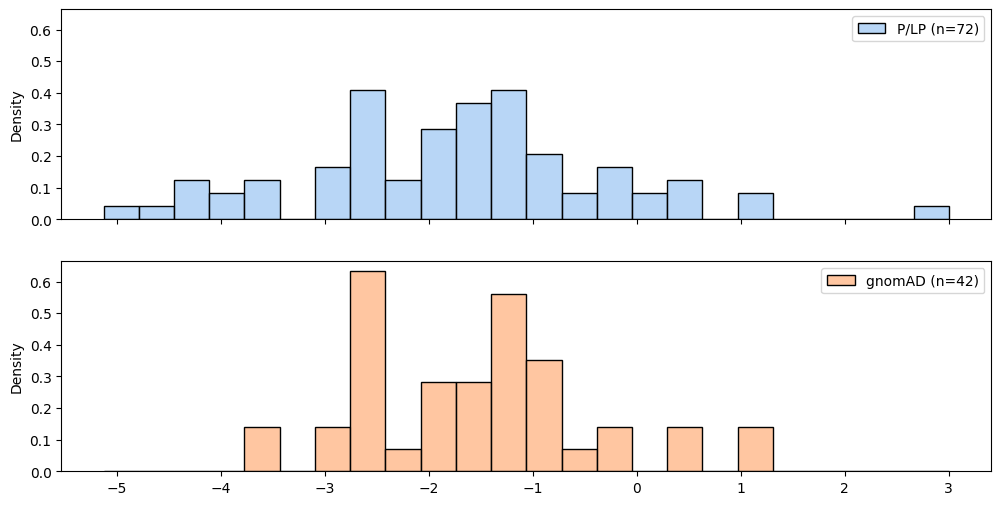

In [29]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [30]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)